# Solution to Exercise 4: Ball-and-stick neuron: Rall versus Eccles

Example code for solving this exercise is found below. 

__(i)__ As seen in the first figure below (execute `exercise_4_1()` at the (almost) bottom of the notebook file), the ball-and-stick neuron model gives the best fit for the normalized charging curve. The figure shows the charging curve of the soma, following the injection of a constant current starting at $t$ = 10 ms for (virtual) experimental data (gray), a lone soma model (blue) and a ball-and-stick model (green). Note that only the shape of the curve matters here as both the lone-soma and ball-and-stick neuron model are linear so that the amplitude is simply proportional to the input current. Note also that this 'best fit' is obtained for a dendritic stick diameter of 2 $\mu$m. Other values for this parameter would give a poorer agreement. Test it out in the Python program yourself!

__(ii)__ The second figure below (execute `exercise_4_2()` at the (almost)bottom of the notebook file) shows the somatic potential response, both in absolute terms (top) and in relative terms (bottom), to a square current pulse lasting 5~ms injected at different dendrite height above the soma (labeled in micrometers). As the figure shows, the somatic voltage response becomes smaller and peaks later when the input is moved farther away from the soma along the dendrite. Thus, the stick dendrite is acting as a lowpass filter, that is, the higher frequency components of the input signal is dampened the most.

__(iii)__ The third figure below (execute `exercise_4_3()` at the bottom of the notebook file) essentially shows the same simulation as we did in __(ii)__, but with Hodgkin-Huxley mechanisms added in the soma of the neuron. The stimulus amplitude was increased so it became strong enough to induce an action potential in the neuron when the synapse was in the soma or close to the soma, but not when it was further out in the dendrite.
  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import neuron
h = neuron.h
h.load_file('stdrun.hoc')

1.0

In [2]:
def return_ball_and_stick_soma():
    """
    Makes a ball-and-stick neuron model.
    :return: soma and dendrite NEURON objects. Both must be returned, or they are lost.
    """
    soma = h.Section('soma')
    soma.L = 15  # um; stored as a float number
    soma.diam = 15  # um
    soma.nseg = 1  # stored as an integer

    dend = h.Section('dend')
    dend.L = 1000
    dend.diam = 2
    dend.nseg = int(dend.L/10)

    dend.connect(soma, 1, 0)

    for sec in h.allsec():
        sec.insert('pas')
        sec.Ra = 100
        sec.cm = 1
        for seg in sec:
            seg.g_pas = 0.00003
            seg.e_pas = -65
    #print "Ball and stick membrane time constant:",  1e-3 * 1/0.0003 * 1
    return soma, dend

In [3]:
def return_lone_soma():
    """
    Makes a neuron model containing a single soma.
    :return: soma NEURON object. This must be returned, or it is lost.
    """

    soma = h.Section('soma')
    soma.L = 15  # um; stored as a float number
    soma.diam = 15  # um
    soma.nseg = 1  # stored as an integer

    for sec in h.allsec():
        sec.insert('pas')
        sec.Ra = 100
        sec.cm = 1
        for seg in sec:
            seg.g_pas = 0.00003
            seg.e_pas = -65
    #print "Lone soma membrane time constant:",  1e-3 * 1/0.0003 * 1
    return soma

In [4]:
def return_ball_and_stick_soma_hh():
    """
    Makes a ball-and-stick neuron model with hh-channels.
    :return: soma and dendrite NEURON objects. Both must be returned, or they are lost.
    """
    
    soma = h.Section('soma')
    soma.L = 15  # um; stored as a float number
    soma.diam = 15  # um
    soma.nseg = 1  # stored as an integer

    dend = h.Section('dend')
    dend.L = 1000
    dend.diam = 2
    dend.nseg = int(dend.L/10)

    dend.connect(soma, 1, 0)

    for sec in h.allsec():
        sec.insert('pas')
        sec.Ra = 100
        sec.cm = 1
        for seg in sec:
            seg.g_pas = 0.00003
            seg.e_pas = -65
    soma.insert('hh')

    return soma, dend

In [5]:
def insert_current_clamp(input_site, dur=1e9, amp = 0.005):
    """
    Inserts a current clamp in the neuron model
    :param input_site: Where to place the current clamp. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
           dur: Duration of the current pulse.
    :return: The NEURON object current clamp. This must be returned, otherwise it is lost.
    """
    stim = h.IClamp(input_site)
    stim.delay = 10
    stim.amp = amp
    stim.dur = dur
    return stim

In [6]:
def run_simulation(record_site):
    """
    Runs the NEURON simulation
    :param record_site: Where to record membrane potential from. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
    :return: Time and voltage numpy arrays
    """
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # Record Voltage from the record site
    rec_v = h.Vector()
    rec_v.record(record_site._ref_v)
    h.dt = 2**-3
    h.finitialize(-65)
    h.init()
    h.continuerun(200)
    return np.array(rec_t), np.array(rec_v)

In [24]:
def exercise_4_1():

    exp_t = np.load('exp_t.npy')
    exp_somav = np.load('exp_v.npy')
    v_norm_exp = (exp_somav - exp_somav[0]) / np.max(np.abs(exp_somav - exp_somav[0]))

    soma_eccles = return_lone_soma()
    stim2 = insert_current_clamp(soma_eccles(0.5))
    t, v_eccles = run_simulation(soma_eccles(0.5))
    v_norm_eccles = (v_eccles - v_eccles[0]) / np.max(np.abs(v_eccles - v_eccles[0]))

    soma_rall, dend_rall = return_ball_and_stick_soma()
    stim1 = insert_current_clamp(soma_rall(0.5))
    t, v_rall = run_simulation(soma_rall(0.5))
    v_norm_rall = (v_rall - v_rall[0]) / np.max(np.abs(v_rall - v_rall[0]))

    # func = lambda tau, args: 1 - np.exp(-t / tau) - args[0]
    # [tau_eccles], cov = leastsq(func, x0=[5], args=[v_norm_eccles])
    # [tau_rall], cov = leastsq(func, x0=[5], args=[v_norm_rall])
    # print tau_eccles, tau_rall

    fig = plt.figure()
    fig.subplots_adjust(wspace=0.5)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, xlim=[0, 100], ylim=[-0.1, 1.1])

    ax1.plot(t, exp_somav, 'gray', label='"Experiment"')
    ax2.plot(t, v_norm_exp, 'gray', label='"Experiment"')

    ax1.plot(t, v_eccles, 'b', label='Eccles')
    ax2.plot(t, v_norm_eccles, 'b', label='Eccles')

    ax1.plot(t, v_rall, 'g', label='Rall')
    ax2.plot(t, v_norm_rall, 'g',  label='Rall')

    ax1.set_xlabel("Time [ms]")
    ax2.set_xlabel("Time [ms]")
    ax1.set_ylabel("Voltage [mV]")
    ax2.set_ylabel("Normalized voltage")
    plt.legend(frameon=False)

    plt.savefig('exercise_4_1.png')

In [25]:
def exercise_4_2():

    dend_positions = np.linspace(0, 1, 5)
    fig = plt.figure()
    fig.subplots_adjust(wspace=0.5)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, xlim=[0, 100], ylim=[-0.1, 1.1])
    soma, dend = return_ball_and_stick_soma()

    h.distance(sec=dend)

    for dend_pos in dend_positions:
        stim = insert_current_clamp(dend(dend_pos), dur=5)
        stim_pos = h.distance(dend_pos, sec=dend)
        t, v = run_simulation(soma(0.5))
        v_norm = (v - v[0]) / np.max(np.abs(v - v[0]))
        ax1.plot(t, v, label='%d' % stim_pos)
        ax2.plot(t, v_norm, label='%d' % stim_pos)

    ax1.set_xlabel("Time [ms]")
    ax2.set_xlabel("Time [ms]")
    ax1.set_ylabel("Voltage [mV]")
    ax2.set_ylabel("Normalized voltage")
    plt.legend(frameon=False)

    plt.savefig('exercise_4_2.png')

In [26]:
def exercise_4_3():

    dend_positions = np.linspace(0, 1, 5)
    fig = plt.figure()
    fig.subplots_adjust(wspace=0.5)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, xlim=[0, 100], ylim=[-0.1, 1.1])
    soma, dend = return_ball_and_stick_soma_hh()

    h.distance(sec=dend)

    for dend_pos in dend_positions:
        stim = insert_current_clamp(dend(dend_pos), dur=5, amp = 0.15)
        stim_pos = h.distance(dend_pos, sec=dend)
        t, v = run_simulation(soma(0.5))
        v_norm = (v - v[0]) / np.max(np.abs(v - v[0]))
        ax1.plot(t, v, label='%d' % stim_pos)
        ax2.plot(t, v_norm, label='%d' % stim_pos)

    ax1.set_xlabel("Time [ms]")
    ax2.set_xlabel("Time [ms]")
    ax1.set_ylabel("Voltage [mV]")
    ax2.set_ylabel("Normalized voltage")
    plt.legend(frameon=False)

    plt.savefig('exercise_4_3.png')

## main simulation: ##

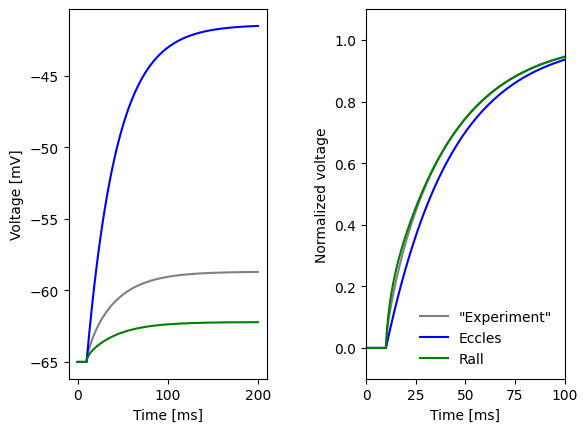

In [27]:
exercise_4_1()

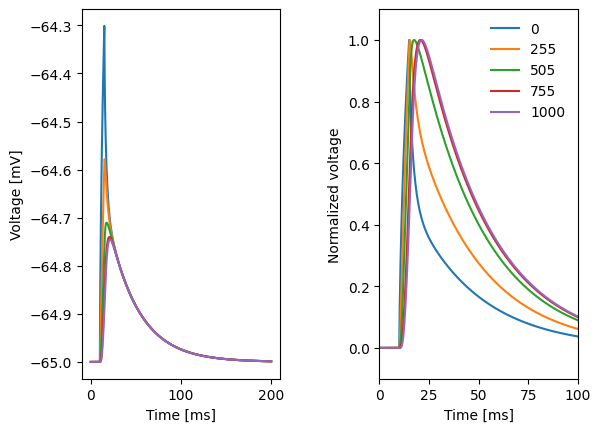

In [28]:
exercise_4_2()

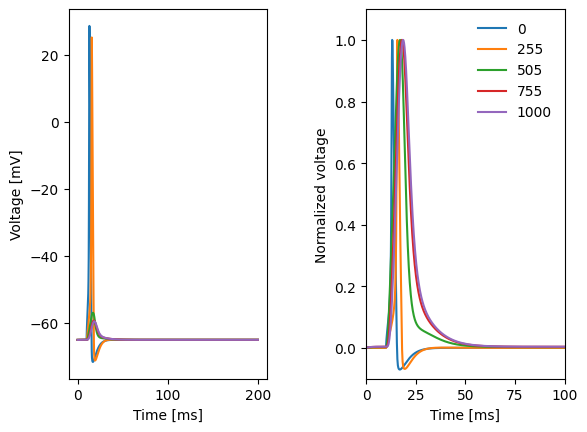

In [29]:
exercise_4_3()